In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import math
import time
import warnings
import re

<h1>1. Preprocesamiento</h1>

<h2>1.1 Normalización</h2>

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [3]:
df_0 = pd.read_csv('Data\Concrete_Data_Yeh.csv')

df_p = preprocessing.normalize(df_0, axis=0)
df = pd.DataFrame(df_p, columns=df_0.columns)
df.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.029208,0.020274,0.020141,0.030946,0.022451,0.031060,0.030993,0.018259,0.028241
std,0.010856,0.023672,0.023786,0.003640,0.021616,0.002482,0.003212,0.025260,0.013172
min,0.010596,0.000000,0.000000,0.020759,0.000000,0.025571,0.023798,0.000400,0.001837
25%,0.019984,0.000000,0.000000,0.028105,0.000000,0.029754,0.029285,0.002799,0.018694
50%,0.028349,0.006036,0.000000,0.031531,0.023158,0.030903,0.031230,0.011197,0.027158
75%,0.036359,0.039220,0.043969,0.032724,0.036908,0.032863,0.033013,0.022393,0.036375
max,0.056096,0.098607,0.074372,0.042098,0.116515,0.036554,0.039768,0.145956,0.065126


<h2>1.2 Selección de por GA con AIC</h2>

<h3>1.2.1 Definición de función a optimizar</h3>

In [4]:
## Definición funcion a optimizar

def aic_criterion(df, var_objetivo):
    
    n_var = len(df.drop(columns=[var_objetivo]).columns)
    n = len(df)
    explicativas = list(df.drop(columns=[var_objetivo]).columns)
    
    y = df[var_objetivo]
    X = df[explicativas]
    
    X_val, X_other, y_val, y_other = train_test_split(X, y, test_size=0.80, random_state=42, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_other, y_other, test_size=0.40, shuffle=False)
    
    del X_other
    del y_other
    
    if X_train.shape[1] > 0:
        reg = OLS(y_train, X_train).fit()
        return(reg.aic)
    else:
        return(10**10)

In [5]:
## Definición funcion a optimizar

def residuales_f(df, df_pend, var_objetivo):
    
    n_var = len(df.drop(columns=[var_objetivo]).columns)
    explicativas = list(df.drop(columns=[var_objetivo]).columns)
    
    y = df[var_objetivo]
    X = df[explicativas]
    
    X_val, X_other, y_val, y_other = train_test_split(X, y, test_size=0.80, random_state=42, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_other, y_other, test_size=0.40, shuffle=False)
    
    del X_other
    del y_other
    
    variables = list(df_pend.index)
    valores = list(df_pend)

    if X_train.shape[1] > 0:
        
        ecuacion = []
        for i in range(len(variables)):
            ecuacion = ecuacion + ['(' + str(valores[i]) + "*df_val['" + str(variables[i]) + "']) +" ]
        ecuacion = ' '.join(ecuacion)[:-2]

        df_val = pd.concat([X_val, y_val], axis=1)
        a = var_objetivo + '_est'
        df_val[a] = eval(ecuacion)
        df_val['residuos'] = df_val[a] - df_val[var_objetivo]

        res_2 = sum(df_val['residuos'].apply(lambda x: x**2)) / len(df_val)

        return(res_2)
    else:
        return(10**10)
    


<h3>1.2.2 Definición de operadores de cruce y mutación</h3>

In [6]:
## Generar operadores de cruce y mutacion

def cruce(cromosoma_0, cromosoma_1, tipo_cruce):
    
    rng = np.random.default_rng()
    largo_cromosoma = len(cromosoma_0)
    rango_cromosoma = range(largo_cromosoma)
    
    if tipo_cruce == 'punto unico':
        
        punto = rng.choice(rango_cromosoma, size=1, replace=False)[0]
        
        descendencia_0 = np.concatenate((cromosoma_0[:punto], cromosoma_1[punto:]), axis = 0)
        descendencia_1 = np.concatenate((cromosoma_1[:punto], cromosoma_0[punto:]), axis = 0)
        
        return(descendencia_0, descendencia_1)
    
    elif tipo_cruce == 'dos puntos':
        
        puntos = rng.choice(rango_cromosoma, size=2, replace=False)
        punto_0 = min(puntos[0], puntos[1])
        punto_1 = max(puntos[0], puntos[1])
        
        descendencia_0 = np.concatenate((cromosoma_0[:punto_0]
                                         , cromosoma_1[punto_0:punto_1]
                                         , cromosoma_0[punto_1:]), axis = 0)
        descendencia_1 = np.concatenate((cromosoma_1[:punto_0]
                                         , cromosoma_0[punto_0:punto_1]
                                         , cromosoma_1[punto_1:]), axis = 0)
        
        return(descendencia_0, descendencia_1)
    
    elif tipo_cruce == 'uniforme':

        padre_0 = np.random.randint(2,size=(len(cromosoma_0), 1))
        padre_1 = (padre_0 - 1) * (- 1)
        
        descendencia_0 = [(padre_0[i] * cromosoma_0[i])[0] + (padre_1[i] * cromosoma_1[i])[0] for i in range(len(cromosoma_0))]
        descendencia_1 = [(padre_0[i] * cromosoma_1[i])[0] + (padre_1[i] * cromosoma_0[i])[0] for i in range(len(cromosoma_0))]
        
        return(descendencia_0, descendencia_1)

    
    
def mutacion(cromosoma_0, df, tipo_dato):
    
    rng = np.random.default_rng()
    largo_cromosoma = len(cromosoma_0)
    rango_cromosoma = range(largo_cromosoma)
    
    gen_mutacion = rng.choice(rango_cromosoma, size=1, replace=False)[0]
    
    if tipo_dato == 'binario':
        
        if cromosoma_0[gen_mutacion] == 1:
            nuevo_gen = 0
        else:
            nuevo_gen = 1
            
        cromosoma_0 = np.concatenate((cromosoma_0[:gen_mutacion]
                                      ,np.array([nuevo_gen])
                                      ,cromosoma_0[gen_mutacion+1:]), axis = 0)
    
    elif tipo_dato == 'flotante':
        
        std_gen = np.std(np.array(df.iloc[:, gen_mutacion]))
        
        nuevo_gen = cromosoma_0[gen_mutacion] + np.random.normal(0, std_gen, 1)
        
        cromosoma_0 = np.concatenate((cromosoma_0[:gen_mutacion]
                                      ,np.array([nuevo_gen])[0]
                                      ,cromosoma_0[gen_mutacion+1:]), axis = 0)
    
    return(cromosoma_0)

<h3>1.2.3 Definición de estrategias de selección</h3>

In [7]:
## Generar funciones de seleccion

def seleccion(df, factor_seleccion, tipo_seleccion, tamano_torneo, tamano_elitismo):
    
    df['seleccionado'] = 0
    
    df_c = df[df['clase']=='C'].reset_index(drop = True)
    df_p = df[df['clase']=='P'].reset_index(drop = True)
    
    if tipo_seleccion == 'ruleta':
        
        df_c['dummy'] = 0
        max_fitness = max(df_c['fitness'])
        min_fitness= min(df_c['fitness'])
        
        if (min_fitness < 0) & (max_fitness >= 0):
            df_c['fitness_escalado'] = (df_c['fitness'] - max_fitness - 1) * (-1)
        elif min_fitness < 0:
            df_c['fitness_escalado'] = df_c['fitness'] * (-1)
        else:
            df_c['fitness_escalado'] = df_c['fitness']
            
            
        total_aic_esc = sum(df_c['fitness_escalado'])
        df_c['prob'] = df_c['fitness_escalado'] / total_aic_esc
        df_c['prob_acum'] = df_c.groupby(['dummy'])['prob'].cumsum()
        df_c['prob_acum_lag'] = df_c['prob_acum'].shift(1).fillna(0)
            
        while (sum(df_c['seleccionado']) / len(df_c)) < factor_seleccion:
                
            rand = np.random.uniform(0, 1)
            df_c['seleccionado'] =  df_c.apply(lambda x: 1 if ((x.prob_acum_lag < rand) 
                                                           & (rand <= x.prob_acum)) else x.seleccionado, axis = 1)

        df_c = df_c.drop(columns=['dummy','fitness_escalado','prob','prob_acum','prob_acum_lag'])
                
    elif tipo_seleccion == 'torneo':
        
        n = len(df_c) - 1
        df_c['fila'] = df_c.index
        
        while (sum(df_c['seleccionado']) / len(df_c)) < factor_seleccion:
                
            rand = list(np.random.choice(np.array(list(df_c[df_c['seleccionado']!=1].index)), tamano_torneo))
            
            df_c['en_torneo'] = df_c.apply(lambda x: 1 if x.fila in rand else 0, axis = 1)
            df_c['min_fitness'] = min(df_c[df_c['en_torneo'] == 1]['fitness'])
            df_c['seleccionado'] =  df_c.apply(lambda x: 1 if ((x.min_fitness == x.fitness)
                                                               & (x.en_torneo == 1)) else x.seleccionado, axis = 1)

        df_c = df_c.drop(columns=['fila','en_torneo','min_fitness'])
    
    if tamano_elitismo > 0:
        df_p['dummy'] = 0
        df_p['orden'] = df_p.sort_values(['fitness']).groupby(['dummy']).cumcount() + 1
        
        df_p['seleccionado'] = df_p.apply(lambda x: 1 if x.orden <= tamano_elitismo else x.seleccionado, axis = 1)
        
        df_p = df_p.drop(columns=['dummy','orden'])
        
    df_final = df_c.append(df_p).reset_index(drop = True)
        
    return(df_final)

<h3>1.2.4 Función Conjunta Final</h3>

In [8]:
# Generar función iterable

def ga_optimizacion(df
                    , var_objetivo
                    , df_parametros
                    , tamano_campeones
                    , factor_mutacion
                    , tipo_dato
                    , factor_seleccion
                    , tipo_seleccion
                    , tamano_torneo
                    , tamano_elitismo
                    , tipo_cruce):
    # Parametros
    
    df_param = df_parametros.copy()
    parametros = list(df_param.columns)  
    
    df_resultados = pd.DataFrame([], columns=['iteracion'
                                              , 'media_fitness'
                                              , 'nro_cromosomas'
                                              , 'nro_variables'
                                              , 'segundos'])
    
    iteracion = 0
    
    contador_crom = 0

    # Tiempo inicio
        
    tiempo_inicio = time.time()
    
    while (len(df_param) > tamano_campeones) or (contador_crom <= 20):
        
        # Marcacion de padres

        df_param['clase'] = 'P'
        df_param['fitness'] = 10 ** 10

        # Nueva Generación por cruce

        df_param = df_param.sample(frac=1).reset_index(drop=True)
        df_param['fila'] = df_param.index + 1
        df_param['grupo_cruce'] = (df_param['fila'].apply(lambda x: x if x % 2 == 0 else x + 1) / 2) - 1

        df_param['seleccionado'] = 0
        df_param['con_mutacion'] = 0
        
        fila_i = len(df_param)

        for j in list(df_param['grupo_cruce'].unique()):

            df_param_2 = df_param[df_param['grupo_cruce']==j][parametros]

            cromosoma_0 = np.array(df_param_2.iloc[0,:])
            cromosoma_1 = np.array(df_param_2.iloc[1,:])

            descend_0, descend_1 = cruce(cromosoma_0, cromosoma_1, tipo_cruce)

            descend_0 = list(descend_0) + ['C'] + [0] + [0] + [j] + [0] + [0]
            descend_1 = list(descend_1) + ['C'] + [0] + [0] + [j] + [0] + [0]

            fila_i = fila_i + 1
            df_param.loc[fila_i] = list(descend_0)
            fila_i = fila_i + 1
            df_param.loc[fila_i] = list(descend_1)

            fila_i = fila_i + 1

        # Generacion de fitness

        for i in range(len(df_param)):

            param_selec = df_param[parametros].iloc[i,:]
            param_selec = list(param_selec[param_selec==1].index) + [var_objetivo]

            df_param['fitness'].iloc[i] = aic_criterion(df[param_selec], var_objetivo)

        df_param = df_param.reset_index(drop = True)

        # Seleccionar mejores e incluir elitismo

        df_param = seleccion(df_param
                                  , factor_seleccion
                                  , tipo_seleccion
                                  , tamano_torneo
                                  , tamano_elitismo)

        df_param = df_param[df_param['seleccionado']==1].reset_index(drop = True)

        df_param['clase'] = 'P'

        
        # Mutación

        df_param = df_param.sample(frac=1).reset_index(drop=True)
        df_param['fila'] = df_param.index + 1
        df_param['con_mutacion'] = df_param['fila'].apply(lambda x: 1 if x < (len(df_param) * factor_mutacion) else 0)

        df_param_m = df_param[df_param['con_mutacion']==1].reset_index(drop = True).copy()

        df_param = df_param[df_param['con_mutacion']==0].reset_index(drop = True).copy()

        
        for k in range(len(df_param_m)):

            cromosoma_antiguo = np.array(df_param_m.drop(columns=['clase'
                                                                       ,'fitness'
                                                                       ,'fila'
                                                                       ,'grupo_cruce'
                                                                       ,'seleccionado'
                                                                       ,'con_mutacion']).iloc[k])

            cromosoma_nuevo = mutacion(cromosoma_antiguo
                                       ,df_param.drop(columns=['clase'
                                                                    ,'fitness'
                                                                    ,'fila'
                                                                    ,'grupo_cruce'
                                                                    ,'seleccionado'
                                                                    ,'con_mutacion'])
                                       ,tipo_dato)

            df_param_m.iloc[k] = list(cromosoma_nuevo) + list(df_param_m[['clase'
                                                                                    ,'fitness'
                                                                                    ,'fila'
                                                                                    ,'grupo_cruce'
                                                                                    ,'seleccionado'
                                                                                    ,'con_mutacion']].iloc[k])

        df_param = df_param.append(df_param_m).reset_index(drop = True)

        
        if len(df_param) % 2 != 0:
            df_param = df_param.sort_values(by = 'fitness').reset_index(drop = True)[0:len(df_param)-1]
        
        # Medición resultados
        
        media_fitness = np.mean(df_param['fitness'])
        nro_cromosomas = len(df_param)
        nro_var = np.mean(df_param.drop(columns=['clase'
                                                      ,'fitness'
                                                      ,'fila'
                                                      ,'grupo_cruce'
                                                      ,'seleccionado']).sum(axis=1))
        iteracion = iteracion + 1
        
        try:
            ult_nro_cromosomas = df_resultados[len(df_resultados)-1:]['nro_cromosomas'].reset_index(drop = True)[0]
        except:
            ult_nro_cromosomas = 0

        print('iteracion: '
              , iteracion
              , ' | fitness: '
              , media_fitness
              , ' | cromosomas: '
              , nro_cromosomas
              , ' | variables: '
              , nro_var
              , ' | segundos: '
              , (time.time() - tiempo_inicio)
             )

        df_resultados.loc[len(df_resultados)] = [iteracion
                                                 , media_fitness
                                                 , nro_cromosomas
                                                 , nro_var
                                                 , time.time() - tiempo_inicio]
        
        if nro_cromosomas == ult_nro_cromosomas:
            contador_crom = contador_crom + 1

    return(df_param, df_resultados)

In [9]:
# Generar función iterable

def ga_optimizacion2(df
                    , var_objetivo
                    , df_parametros
                    , tamano_campeones
                    , factor_mutacion
                    , tipo_dato
                    , factor_seleccion
                    , tipo_seleccion
                    , tamano_torneo
                    , tamano_elitismo
                    , tipo_cruce):
    # Parametros
    
    df_param = df_parametros.copy()
    parametros = list(df_param.columns)  
    
    df_resultados = pd.DataFrame([], columns=['iteracion'
                                              , 'media_fitness'
                                              , 'nro_cromosomas'
                                              , 'nro_variables'
                                              , 'segundos'])
    
    iteracion = 0
    
    contador_crom = 0

    # Tiempo inicio
        
    tiempo_inicio = time.time()
    
    while (len(df_param) > tamano_campeones) or (contador_crom <= 20):
        
        # Marcacion de padres

        df_param['clase'] = 'P'
        df_param['fitness'] = 10 ** 10

        # Nueva Generación por cruce

        df_param = df_param.sample(frac=1).reset_index(drop=True)
        df_param['fila'] = df_param.index + 1
        df_param['grupo_cruce'] = (df_param['fila'].apply(lambda x: x if x % 2 == 0 else x + 1) / 2) - 1

        df_param['seleccionado'] = 0
        df_param['con_mutacion'] = 0
        
        fila_i = len(df_param)

        for j in list(df_param['grupo_cruce'].unique()):

            df_param_2 = df_param[df_param['grupo_cruce']==j][parametros]

            cromosoma_0 = np.array(df_param_2.iloc[0,:])
            cromosoma_1 = np.array(df_param_2.iloc[1,:])

            descend_0, descend_1 = cruce(cromosoma_0, cromosoma_1, tipo_cruce)

            descend_0 = list(descend_0) + ['C'] + [0] + [0] + [j] + [0] + [0]
            descend_1 = list(descend_1) + ['C'] + [0] + [0] + [j] + [0] + [0]

            fila_i = fila_i + 1
            df_param.loc[fila_i] = list(descend_0)
            fila_i = fila_i + 1
            df_param.loc[fila_i] = list(descend_1)

            fila_i = fila_i + 1

        # Generacion de fitness
        
        for i in range(len(df_param)):

            param_selec = df_param[parametros].iloc[i,:]

            df_param['fitness'].iloc[i] = residuales_f(df, param_selec, var_objetivo)

        df_param = df_param.reset_index(drop = True)
        
        # Seleccionar mejores e incluir elitismo

        df_param = seleccion(df_param
                                  , factor_seleccion
                                  , tipo_seleccion
                                  , tamano_torneo
                                  , tamano_elitismo)

        df_param = df_param[df_param['seleccionado']==1].reset_index(drop = True)

        df_param['clase'] = 'P'

        # Mutación

        df_param = df_param.sample(frac=1).reset_index(drop=True)
        df_param['fila'] = df_param.index + 1
        df_param['con_mutacion'] = df_param['fila'].apply(lambda x: 1 if x < (len(df_param) * factor_mutacion) else 0)

        df_param_m = df_param[df_param['con_mutacion']==1].reset_index(drop = True).copy()

        df_param = df_param[df_param['con_mutacion']==0].reset_index(drop = True).copy()

        
        for k in range(len(df_param_m)):

            cromosoma_antiguo = np.array(df_param_m.drop(columns=['clase'
                                                                       ,'fitness'
                                                                       ,'fila'
                                                                       ,'grupo_cruce'
                                                                       ,'seleccionado'
                                                                       ,'con_mutacion']).iloc[k])

            cromosoma_nuevo = mutacion(cromosoma_antiguo
                                       ,df_param.drop(columns=['clase'
                                                                    ,'fitness'
                                                                    ,'fila'
                                                                    ,'grupo_cruce'
                                                                    ,'seleccionado'
                                                                    ,'con_mutacion'])
                                       ,tipo_dato)

            df_param_m.iloc[k] = list(cromosoma_nuevo) + list(df_param_m[['clase'
                                                                                    ,'fitness'
                                                                                    ,'fila'
                                                                                    ,'grupo_cruce'
                                                                                    ,'seleccionado'
                                                                                    ,'con_mutacion']].iloc[k])

        df_param = df_param.append(df_param_m).reset_index(drop = True)

        
        if len(df_param) % 2 != 0:
            df_param = df_param.sort_values(by = 'fitness').reset_index(drop = True)[0:len(df_param)-1]
        
        # Medición resultados
        
        media_fitness = np.mean(df_param['fitness'])
        nro_cromosomas = len(df_param)
        nro_var = np.mean(df_param.drop(columns=['clase'
                                                      ,'fitness'
                                                      ,'fila'
                                                      ,'grupo_cruce'
                                                      ,'seleccionado']).sum(axis=1))
        iteracion = iteracion + 1
        
        try:
            ult_nro_cromosomas = df_resultados[len(df_resultados)-1:]['nro_cromosomas'].reset_index(drop = True)[0]
        except:
            ult_nro_cromosomas = 0

        print('iteracion: '
              , iteracion
              , ' | fitness: '
              , media_fitness
              , ' | cromosomas: '
              , nro_cromosomas
              , ' | variables: '
              , nro_var
              , ' | segundos: '
              , (time.time() - tiempo_inicio)
             )

        df_resultados.loc[len(df_resultados)] = [iteracion
                                                 , media_fitness
                                                 , nro_cromosomas
                                                 , nro_var
                                                 , time.time() - tiempo_inicio]
        
        if nro_cromosomas == ult_nro_cromosomas:
            contador_crom = contador_crom + 1

    return(df_param, df_resultados)

<h3>1.2.5 Generación de dataset con nuevos parámetros</h3>

In [10]:
## Generación de realciones

columnas = list(df.drop(columns=['csMPa']).columns)
for i in columnas:
    columnas_2 = [x for x in columnas if x not in i]
    for j in columnas_2:
        nombre_columna = i + '-' + j
        df[nombre_columna] = df[i] / df[j]

## Quitar varibales con valores no indeterminados

df = df[list(df.describe().replace([np.inf, -np.inf], np.nan).iloc[-1].dropna().index)]

pattern = re.compile(r'^.*age.*$')
df = df.drop(columns = [x for x in df.columns if ((pattern.match(x)) and (x != 'age'))])

## Generación de Exponenciales

#columnas = list(df.drop(columns=['csMPa']).columns)

#for i in columnas:
    #nombre_columna = 'exp_' + i
    #df[nombre_columna] = df[i].apply(lambda x: math.exp(x))

<h3>1.2.6 Generación de dataset con nuevas variables</h3>

In [11]:
np.random.seed(1984)

variables = list(df.drop(columns=['csMPa']).columns)
df_variables = pd.DataFrame([np.random.choice(2, len(variables), p=[0.9, 0.1]) for x in range(500)]
                            ,columns=variables)

<h3>1.2.7 Pruebas Seleccion de Variables</h3>

In [62]:
np.random.seed(1985)

df_prueba_0 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.95
                              , tipo_seleccion = 'ruleta'
                              
                              
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_0[0].to_csv('Data/df_var_1.csv')
df_prueba_0[1].to_csv('Data/df_result_var_1.csv')

KeyError: "['flyash-coarseaggregate'] not in index"

In [13]:
np.random.seed(1985)

df_prueba_1 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 18
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_1[0].to_csv('Data/df_var_2.csv')
df_prueba_1[1].to_csv('Data/df_result_var_2.csv')

iteracion:  1  | fitness:  -3006.5092693693746  | cromosomas:  450  | variables:  3.7511111111111113  | segundos:  30.749011516571045
iteracion:  2  | fitness:  -3041.812179387406  | cromosomas:  406  | variables:  4.0492610837438425  | segundos:  56.60501170158386
iteracion:  3  | fitness:  -3070.664114048165  | cromosomas:  366  | variables:  4.330601092896175  | segundos:  78.74601197242737
iteracion:  4  | fitness:  -3087.2235717855333  | cromosomas:  330  | variables:  4.648484848484848  | segundos:  97.81601190567017
iteracion:  5  | fitness:  -3100.3809089429687  | cromosomas:  298  | variables:  4.926174496644295  | segundos:  113.91500329971313
iteracion:  6  | fitness:  -3116.9305850563273  | cromosomas:  270  | variables:  5.225925925925926  | segundos:  127.76801204681396
iteracion:  7  | fitness:  -3129.992607838483  | cromosomas:  244  | variables:  5.528688524590164  | segundos:  139.6289987564087
iteracion:  8  | fitness:  -3147.5923745948035  | cromosomas:  220  | vari

In [14]:
np.random.seed(1985)

df_prueba_2 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 12
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.85
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_2[0].to_csv('Data/df_var_3.csv')
df_prueba_2[1].to_csv('Data/df_result_var_3.csv')

iteracion:  1  | fitness:  -3025.3868117552515  | cromosomas:  426  | variables:  3.8661971830985915  | segundos:  29.40300440788269
iteracion:  2  | fitness:  -3065.192891665572  | cromosomas:  364  | variables:  4.214285714285714  | segundos:  52.28001260757446
iteracion:  3  | fitness:  -3092.918161541918  | cromosomas:  310  | variables:  4.616129032258065  | segundos:  70.36901259422302
iteracion:  4  | fitness:  -3114.063465158562  | cromosomas:  264  | variables:  5.03030303030303  | segundos:  84.44601249694824
iteracion:  5  | fitness:  -3132.298666593422  | cromosomas:  226  | variables:  5.393805309734513  | segundos:  95.59801292419434
iteracion:  6  | fitness:  -3149.2224165067287  | cromosomas:  194  | variables:  5.788659793814433  | segundos:  104.49901247024536
iteracion:  7  | fitness:  -3168.1035151486003  | cromosomas:  166  | variables:  6.156626506024097  | segundos:  111.72399973869324
iteracion:  8  | fitness:  -3182.6898288050925  | cromosomas:  142  | variable

In [15]:
np.random.seed(1985)

df_prueba_3 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 10
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_3[0].to_csv('Data/df_var_4.csv')
df_prueba_3[1].to_csv('Data/df_result_var_4.csv')

iteracion:  1  | fitness:  -3034.1620410997116  | cromosomas:  400  | variables:  3.9275  | segundos:  28.450013875961304
iteracion:  2  | fitness:  -3084.050595952005  | cromosomas:  320  | variables:  4.390625  | segundos:  48.522013664245605
iteracion:  3  | fitness:  -3108.7488479308477  | cromosomas:  256  | variables:  4.78515625  | segundos:  63.003015995025635
iteracion:  4  | fitness:  -3135.9334863705394  | cromosomas:  206  | variables:  5.242718446601942  | segundos:  73.39101338386536
iteracion:  5  | fitness:  -3156.502446124763  | cromosomas:  166  | variables:  5.668674698795181  | segundos:  81.01201343536377
iteracion:  6  | fitness:  -3167.0158025161672  | cromosomas:  134  | variables:  6.134328358208955  | segundos:  86.78101301193237
iteracion:  7  | fitness:  -3185.1233548099444  | cromosomas:  108  | variables:  6.583333333333333  | segundos:  91.13000154495239
iteracion:  8  | fitness:  -3203.327044151867  | cromosomas:  88  | variables:  6.875  | segundos:  94

In [16]:
print(np.mean(df_prueba_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_2[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_3[0].sort_values('fitness')[0:10]['fitness']))

-3390.1057185504956 -3402.2076655555807 -3389.982838171554 -3390.016824932554


In [17]:
np.random.seed(1985)

df_prueba_1_0 = ga_optimizacion(df = df
                                , var_objetivo = 'csMPa'
                                , df_parametros = df_variables
                                , tamano_campeones = 18
                                , factor_mutacion = 0.1
                                , tipo_dato = 'binario'
                                , factor_seleccion = 0.90
                                , tipo_seleccion = 'torneo'
                                , tamano_torneo = 10
                                , tamano_elitismo = 1
                                , tipo_cruce = 'punto unico'
                               )

df_prueba_1_0[0].to_csv('Data/df_var_5.csv')
df_prueba_1_0[1].to_csv('Data/df_result_var_5.csv')

iteracion:  1  | fitness:  -3007.0727946664138  | cromosomas:  450  | variables:  3.7711111111111113  | segundos:  30.76801061630249
iteracion:  2  | fitness:  -3045.0419281445797  | cromosomas:  406  | variables:  3.997536945812808  | segundos:  56.86901044845581
iteracion:  3  | fitness:  -3068.078659541882  | cromosomas:  366  | variables:  4.262295081967213  | segundos:  78.9259979724884
iteracion:  4  | fitness:  -3086.341580909027  | cromosomas:  330  | variables:  4.566666666666666  | segundos:  97.63599944114685
iteracion:  5  | fitness:  -3108.6013316504377  | cromosomas:  298  | variables:  4.895973154362416  | segundos:  113.72801089286804
iteracion:  6  | fitness:  -3125.898209957754  | cromosomas:  270  | variables:  5.185185185185185  | segundos:  127.6280107498169
iteracion:  7  | fitness:  -3133.072718844926  | cromosomas:  244  | variables:  5.508196721311475  | segundos:  139.66301083564758
iteracion:  8  | fitness:  -3146.4363314991133  | cromosomas:  220  | variable

In [18]:
np.random.seed(1985)

df_prueba_1_1 = ga_optimizacion(df = df
                                , var_objetivo = 'csMPa'
                                , df_parametros = df_variables
                                , tamano_campeones = 18
                                , factor_mutacion = 0.1
                                , tipo_dato = 'binario'
                                , factor_seleccion = 0.90
                                , tipo_seleccion = 'torneo'
                                , tamano_torneo = 15
                                , tamano_elitismo = 1
                                , tipo_cruce = 'punto unico'
                               )

df_prueba_1_1[0].to_csv('Data/df_var_6.csv')
df_prueba_1_1[1].to_csv('Data/df_result_var_6.csv')

iteracion:  1  | fitness:  -3007.1011308850307  | cromosomas:  450  | variables:  3.7822222222222224  | segundos:  31.063013553619385
iteracion:  2  | fitness:  -3041.2677391687307  | cromosomas:  406  | variables:  4.078817733990148  | segundos:  57.32801342010498
iteracion:  3  | fitness:  -3067.311120532279  | cromosomas:  366  | variables:  4.3497267759562845  | segundos:  79.68001341819763
iteracion:  4  | fitness:  -3089.1782056386464  | cromosomas:  330  | variables:  4.666666666666667  | segundos:  98.54601335525513
iteracion:  5  | fitness:  -3103.8532494046417  | cromosomas:  298  | variables:  4.993288590604027  | segundos:  114.74701309204102
iteracion:  6  | fitness:  -3120.0446481025388  | cromosomas:  270  | variables:  5.285185185185185  | segundos:  128.6660132408142
iteracion:  7  | fitness:  -3137.3520597489214  | cromosomas:  244  | variables:  5.672131147540983  | segundos:  140.6200134754181
iteracion:  8  | fitness:  -3153.6155333763886  | cromosomas:  220  | var

In [19]:
print(np.mean(df_prueba_1[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_1[0].sort_values('fitness')[0:10]['fitness']))

-3402.2076655555807 -3398.0453097213117 -3399.453774321977


In [20]:
np.random.seed(1985)

df_prueba_1_0 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 18
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'ruleta'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_1_0[0].to_csv('Data/df_var_7.csv')
df_prueba_1_0[1].to_csv('Data/df_result_var_7.csv')

iteracion:  1  | fitness:  -2962.5343497649965  | cromosomas:  450  | variables:  3.668888888888889  | segundos:  45.67501139640808
iteracion:  2  | fitness:  -2981.952316775576  | cromosomas:  406  | variables:  3.8669950738916254  | segundos:  78.84301161766052
iteracion:  3  | fitness:  -2998.702956049783  | cromosomas:  366  | variables:  4.01912568306011  | segundos:  108.14201140403748
iteracion:  4  | fitness:  -3003.5107741550605  | cromosomas:  330  | variables:  4.093939393939394  | segundos:  132.24999904632568
iteracion:  5  | fitness:  -3018.5204616659385  | cromosomas:  298  | variables:  4.241610738255034  | segundos:  150.95199847221375
iteracion:  6  | fitness:  -3017.3232070973395  | cromosomas:  270  | variables:  4.314814814814815  | segundos:  168.09101152420044
iteracion:  7  | fitness:  -3031.6123695998367  | cromosomas:  244  | variables:  4.409836065573771  | segundos:  181.93701171875
iteracion:  8  | fitness:  -3035.7725172480527  | cromosomas:  220  | variab

In [21]:
print(np.mean(df_prueba_1[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_0[0].sort_values('fitness')[0:10]['fitness']))

-3402.2076655555807 -3385.8864422721513


In [22]:
np.random.seed(1985)

df_prueba_1_0 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 28
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 2
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_1_0[0].to_csv('Data/df_var_8.csv')
df_prueba_1_0[1].to_csv('Data/df_result_var_8.csv')

iteracion:  1  | fitness:  -3006.5083973176456  | cromosomas:  452  | variables:  3.7831858407079646  | segundos:  30.513012170791626
iteracion:  2  | fitness:  -3047.9576022351835  | cromosomas:  408  | variables:  4.1004901960784315  | segundos:  56.701011657714844
iteracion:  3  | fitness:  -3071.6535817001145  | cromosomas:  370  | variables:  4.364864864864865  | segundos:  78.8750114440918
iteracion:  4  | fitness:  -3090.8803178426733  | cromosomas:  334  | variables:  4.727544910179641  | segundos:  97.87601137161255
iteracion:  5  | fitness:  -3108.5078877473297  | cromosomas:  302  | variables:  5.096026490066225  | segundos:  114.18901181221008
iteracion:  6  | fitness:  -3127.301629271006  | cromosomas:  274  | variables:  5.408759124087592  | segundos:  128.2360122203827
iteracion:  7  | fitness:  -3140.10330956197  | cromosomas:  248  | variables:  5.701612903225806  | segundos:  140.33901143074036
iteracion:  8  | fitness:  -3152.1832099307762  | cromosomas:  226  | vari

In [23]:
np.random.seed(1985)

df_prueba_1_1 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 58
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 5
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_1_1[0].to_csv('Data/df_var_9.csv')
df_prueba_1_1[1].to_csv('Data/df_result_var_9.csv')

iteracion:  1  | fitness:  -3009.427697455756  | cromosomas:  454  | variables:  3.806167400881057  | segundos:  30.530012130737305
iteracion:  2  | fitness:  -3052.476759958202  | cromosomas:  414  | variables:  4.1231884057971016  | segundos:  56.92601203918457
iteracion:  3  | fitness:  -3080.567753665172  | cromosomas:  378  | variables:  4.441798941798941  | segundos:  79.47401285171509
iteracion:  4  | fitness:  -3102.9831961633813  | cromosomas:  346  | variables:  4.794797687861272  | segundos:  99.14601230621338
iteracion:  5  | fitness:  -3125.1828883239136  | cromosomas:  316  | variables:  5.151898734177215  | segundos:  116.43901252746582
iteracion:  6  | fitness:  -3142.0562373866164  | cromosomas:  290  | variables:  5.5137931034482754  | segundos:  131.66801238059998
iteracion:  7  | fitness:  -3160.3370725867535  | cromosomas:  266  | variables:  5.890977443609023  | segundos:  144.85601234436035
iteracion:  8  | fitness:  -3177.885394949048  | cromosomas:  244  | vari

In [24]:
np.random.seed(1985)

df_prueba_1_2 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 108
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 10
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_1_2[0].to_csv('Data/df_var_10.csv')
df_prueba_1_2[1].to_csv('Data/df_result_var_10.csv')

iteracion:  1  | fitness:  -3005.555754334187  | cromosomas:  460  | variables:  3.8195652173913044  | segundos:  30.744012594223022
iteracion:  2  | fitness:  -3050.410562026803  | cromosomas:  424  | variables:  4.162735849056604  | segundos:  57.67799949645996
iteracion:  3  | fitness:  -3084.187690763583  | cromosomas:  392  | variables:  4.50765306122449  | segundos:  81.37699937820435
iteracion:  4  | fitness:  -3111.300888487428  | cromosomas:  362  | variables:  4.900552486187845  | segundos:  102.33101224899292
iteracion:  5  | fitness:  -3133.0393693522133  | cromosomas:  336  | variables:  5.285714285714286  | segundos:  120.7910008430481
iteracion:  6  | fitness:  -3155.1600201387005  | cromosomas:  312  | variables:  5.756410256410256  | segundos:  137.35101222991943
iteracion:  7  | fitness:  -3181.019716538514  | cromosomas:  290  | variables:  6.258620689655173  | segundos:  152.13001227378845
iteracion:  8  | fitness:  -3201.822861593626  | cromosomas:  270  | variable

In [25]:
print(np.mean(df_prueba_1[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_1[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_2[0].sort_values('fitness')[0:10]['fitness']))

-3402.2076655555807 -3402.8870159329663 -3403.3647916396417 -3406.1776192315288


In [26]:
np.random.seed(1985)

df_prueba_1_2_0 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 108
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 10
                              , tipo_cruce = 'dos puntos'
                             )

df_prueba_1_2_0[0].to_csv('Data/df_var_11.csv')
df_prueba_1_2_0[1].to_csv('Data/df_result_var_11.csv')

iteracion:  1  | fitness:  -3003.2967614720033  | cromosomas:  460  | variables:  3.8304347826086955  | segundos:  30.561012506484985
iteracion:  2  | fitness:  -3049.666631181897  | cromosomas:  424  | variables:  4.21933962264151  | segundos:  57.3480122089386
iteracion:  3  | fitness:  -3084.954729093421  | cromosomas:  392  | variables:  4.591836734693878  | segundos:  80.86101222038269
iteracion:  4  | fitness:  -3114.3063879620004  | cromosomas:  362  | variables:  5.005524861878453  | segundos:  101.81601214408875
iteracion:  5  | fitness:  -3136.0452585052885  | cromosomas:  336  | variables:  5.413690476190476  | segundos:  120.28501200675964
iteracion:  6  | fitness:  -3158.2222357824844  | cromosomas:  312  | variables:  5.8493589743589745  | segundos:  136.6810121536255
iteracion:  7  | fitness:  -3179.976249542164  | cromosomas:  290  | variables:  6.26551724137931  | segundos:  151.4269986152649
iteracion:  8  | fitness:  -3201.475145790732  | cromosomas:  270  | variable

In [27]:
np.random.seed(1985)

df_prueba_1_2_1 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 108
                              , factor_mutacion = 0.1
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 10
                              , tipo_cruce = 'uniforme'
                             )

df_prueba_1_2_1[0].to_csv('Data/df_var_12.csv')
df_prueba_1_2_1[1].to_csv('Data/df_result_var_12.csv')

iteracion:  1  | fitness:  -3005.860251966027  | cromosomas:  460  | variables:  3.8065217391304347  | segundos:  30.612010955810547
iteracion:  2  | fitness:  -3055.1849491558387  | cromosomas:  424  | variables:  4.19811320754717  | segundos:  57.53701090812683
iteracion:  3  | fitness:  -3087.360680828758  | cromosomas:  392  | variables:  4.594387755102041  | segundos:  81.32801103591919
iteracion:  4  | fitness:  -3106.5798773366582  | cromosomas:  362  | variables:  5.0  | segundos:  102.28801345825195
iteracion:  5  | fitness:  -3134.073994903108  | cromosomas:  336  | variables:  5.461309523809524  | segundos:  120.73201060295105
iteracion:  6  | fitness:  -3153.8353688439634  | cromosomas:  312  | variables:  5.897435897435898  | segundos:  137.24499940872192
iteracion:  7  | fitness:  -3174.698648278269  | cromosomas:  290  | variables:  6.431034482758621  | segundos:  152.04701137542725
iteracion:  8  | fitness:  -3196.2447666590756  | cromosomas:  270  | variables:  6.91851

In [28]:
print(np.mean(df_prueba_1_2[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_2_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_2_1[0].sort_values('fitness')[0:10]['fitness']))

-3406.1776192315288 -3405.8057362069317 -3401.561806104487


In [29]:
np.random.seed(1985)

df_prueba_1_2_0 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 108
                              , factor_mutacion = 0.2
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 10
                              , tipo_cruce = 'uniforme'
                             )

df_prueba_1_2_0[0].to_csv('Data/df_var_13.csv')
df_prueba_1_2_0[1].to_csv('Data/df_result_var_13.csv')

iteracion:  1  | fitness:  -3005.860251966027  | cromosomas:  460  | variables:  3.993478260869565  | segundos:  31.059012174606323
iteracion:  2  | fitness:  -3052.9967116134594  | cromosomas:  424  | variables:  4.474056603773585  | segundos:  58.310012102127075
iteracion:  3  | fitness:  -3090.0983830318823  | cromosomas:  392  | variables:  4.913265306122449  | segundos:  82.25601196289062
iteracion:  4  | fitness:  -3113.6487835072553  | cromosomas:  362  | variables:  5.31767955801105  | segundos:  103.57400393486023
iteracion:  5  | fitness:  -3130.9498635661225  | cromosomas:  336  | variables:  5.785714285714286  | segundos:  122.2560122013092
iteracion:  6  | fitness:  -3155.7179581530854  | cromosomas:  312  | variables:  6.256410256410256  | segundos:  139.02201199531555
iteracion:  7  | fitness:  -3180.4432592819253  | cromosomas:  290  | variables:  6.751724137931035  | segundos:  154.09001207351685
iteracion:  8  | fitness:  -3196.115957512154  | cromosomas:  270  | vari

In [30]:
np.random.seed(1985)

df_prueba_1_2_1 = ga_optimizacion(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_variables
                              , tamano_campeones = 108
                              , factor_mutacion = 0.3
                              , tipo_dato = 'binario'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 10
                              , tipo_cruce = 'uniforme'
                             )

df_prueba_1_2_1[0].to_csv('Data/df_var_14.csv')
df_prueba_1_2_1[1].to_csv('Data/df_result_var_14.csv')

iteracion:  1  | fitness:  -3005.8602519660276  | cromosomas:  460  | variables:  4.176086956521739  | segundos:  31.53999972343445
iteracion:  2  | fitness:  -3063.871866326261  | cromosomas:  424  | variables:  4.705188679245283  | segundos:  59.10901236534119
iteracion:  3  | fitness:  -3096.873322020156  | cromosomas:  392  | variables:  5.24234693877551  | segundos:  83.43100190162659
iteracion:  4  | fitness:  -3126.5759362301856  | cromosomas:  362  | variables:  5.803867403314917  | segundos:  104.95301222801208
iteracion:  5  | fitness:  -3154.1847315828745  | cromosomas:  336  | variables:  6.369047619047619  | segundos:  123.91899991035461
iteracion:  6  | fitness:  -3177.5289511211467  | cromosomas:  312  | variables:  6.910256410256411  | segundos:  141.103999376297
iteracion:  7  | fitness:  -3195.493679116791  | cromosomas:  290  | variables:  7.472413793103448  | segundos:  156.3570008277893
iteracion:  8  | fitness:  -3218.062559594776  | cromosomas:  270  | variables:

In [31]:
print(np.mean(df_prueba_1_2[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_2_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_1_2_1[0].sort_values('fitness')[0:10]['fitness']))

-3406.1776192315288 -3406.0769032806807 -3407.067303288311


In [124]:
mejores_var = df_prueba_1_2_1[0].sort_values('fitness').drop(columns = ['grupo_cruce'
                                                                      , 'seleccionado'
                                                                      , 'fila']).reset_index(drop = True)[0:100].describe().iloc[1,:]
mejores_var = list(mejores_var[mejores_var>=0.9].index)

mejores_var

['cement',
 'slag',
 'water',
 'age',
 'cement-water',
 'slag-fineaggregate',
 'flyash-cement',
 'flyash-water',
 'flyash-coarseaggregate',
 'water-cement',
 'superplasticizer-cement',
 'coarseaggregate-cement',
 'coarseaggregate-water']

<h2>1.3 Estimación de parámetros de por GA con minimización de RMSE</h2>

<h3>1.3.1 Generación de dataset con posibles parámetros</h3>

In [33]:
np.random.seed(2021)

variables_modelo = mejores_var+['csMPa']

df = df[variables_modelo]

df_pendientes = pd.DataFrame([np.random.choice(5
                                               , len(mejores_var)
                                               , p=[0.2, 0.2, 0.2, 0.2, 0.2]) for x in range(500)]
                            ,columns=mejores_var)

df_pendientes = df_pendientes / 4

In [34]:
np.random.seed(2022)

df_prueba_param_0 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.95
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_0[0].to_csv('Data/df_var_15.csv')
df_prueba_param_0[1].to_csv('Data/df_result_var_15.csv')

iteracion:  1  | fitness:  11.294497612610492  | cromosomas:  476  | variables:  5.563315922490703  | segundos:  33.282999992370605
iteracion:  2  | fitness:  10.793735801327726  | cromosomas:  454  | variables:  5.490272945974868  | segundos:  64.43800020217896
iteracion:  3  | fitness:  10.210343560396325  | cromosomas:  432  | variables:  5.397656847130329  | segundos:  92.8620138168335
iteracion:  4  | fitness:  9.762318714764774  | cromosomas:  412  | variables:  5.320913142956955  | segundos:  119.59700012207031
iteracion:  5  | fitness:  9.140197689441607  | cromosomas:  392  | variables:  5.231404429333968  | segundos:  144.17101407051086
iteracion:  6  | fitness:  8.668880041725929  | cromosomas:  374  | variables:  5.1330100264269065  | segundos:  166.9779999256134
iteracion:  7  | fitness:  8.109239235408351  | cromosomas:  356  | variables:  5.026194992751811  | segundos:  188.30501294136047
iteracion:  8  | fitness:  7.637340801815542  | cromosomas:  340  | variables:  4.9

iteracion:  64  | fitness:  0.03493065536045273  | cromosomas:  38  | variables:  1.590127544901671  | segundos:  501.52000188827515
iteracion:  65  | fitness:  0.03440196834756069  | cromosomas:  38  | variables:  1.5538051901422243  | segundos:  502.6650128364563
iteracion:  66  | fitness:  0.029561833576040725  | cromosomas:  38  | variables:  1.4862327310787868  | segundos:  503.8090000152588
iteracion:  67  | fitness:  0.028107841365333328  | cromosomas:  38  | variables:  1.4688095604249272  | segundos:  504.9540138244629
iteracion:  68  | fitness:  0.02572664800257786  | cromosomas:  38  | variables:  1.4339992411325901  | segundos:  506.1000130176544
iteracion:  69  | fitness:  0.02738209230373048  | cromosomas:  38  | variables:  1.3764654677100352  | segundos:  507.2420001029968
iteracion:  70  | fitness:  0.02260467603818839  | cromosomas:  38  | variables:  1.3086591605003195  | segundos:  508.38700103759766
iteracion:  71  | fitness:  0.021275373136046372  | cromosomas:  3

In [35]:
np.random.seed(2022)

df_prueba_param_1 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.90
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_1[0].to_csv('Data/df_var_16.csv')
df_prueba_param_1[1].to_csv('Data/df_result_var_16.csv')

iteracion:  1  | fitness:  10.71007838618988  | cromosomas:  450  | variables:  5.459301146892225  | segundos:  32.27300000190735
iteracion:  2  | fitness:  9.689253325114294  | cromosomas:  406  | variables:  5.301175853478668  | segundos:  59.42999792098999
iteracion:  3  | fitness:  8.847758929976758  | cromosomas:  366  | variables:  5.171260966853504  | segundos:  82.64301133155823
iteracion:  4  | fitness:  8.008796933791633  | cromosomas:  330  | variables:  5.023052858407354  | segundos:  102.48899817466736
iteracion:  5  | fitness:  7.28299723114555  | cromosomas:  298  | variables:  4.880600897778769  | segundos:  119.31799817085266
iteracion:  6  | fitness:  6.6041055438455  | cromosomas:  270  | variables:  4.7234622791788095  | segundos:  133.97399830818176
iteracion:  7  | fitness:  5.92507413620317  | cromosomas:  244  | variables:  4.570508731665776  | segundos:  146.66299867630005
iteracion:  8  | fitness:  5.2146970072935925  | cromosomas:  220  | variables:  4.445334

In [36]:
np.random.seed(2022)

df_prueba_param_2 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.85
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_2[0].to_csv('Data/df_var_17.csv')
df_prueba_param_2[1].to_csv('Data/df_result_var_17.csv')

iteracion:  1  | fitness:  10.271480556683677  | cromosomas:  426  | variables:  5.4251636491302975  | segundos:  30.91399645805359
iteracion:  2  | fitness:  8.937537117087032  | cromosomas:  364  | variables:  5.245304317813092  | segundos:  54.960001945495605
iteracion:  3  | fitness:  7.804351654757587  | cromosomas:  310  | variables:  5.049703385516071  | segundos:  73.8159966468811
iteracion:  4  | fitness:  6.727233307693898  | cromosomas:  264  | variables:  4.859970120785639  | segundos:  88.87499833106995
iteracion:  5  | fitness:  5.83473805267839  | cromosomas:  226  | variables:  4.661218487506196  | segundos:  100.76099872589111
iteracion:  6  | fitness:  4.919505600515022  | cromosomas:  194  | variables:  4.48893137873701  | segundos:  110.28899693489075
iteracion:  7  | fitness:  4.199309671396494  | cromosomas:  166  | variables:  4.314803441645621  | segundos:  118.06500959396362
iteracion:  8  | fitness:  3.47089585457914  | cromosomas:  142  | variables:  4.166703

In [37]:
np.random.seed(2022)

df_prueba_param_3 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_3[0].to_csv('Data/df_var_18.csv')
df_prueba_param_3[1].to_csv('Data/df_result_var_18.csv')

iteracion:  1  | fitness:  9.744105666399745  | cromosomas:  400  | variables:  5.338544668348489  | segundos:  29.84801149368286
iteracion:  2  | fitness:  8.017476066602237  | cromosomas:  320  | variables:  5.0586320801587386  | segundos:  51.13601112365723
iteracion:  3  | fitness:  6.651154961858789  | cromosomas:  256  | variables:  4.823065559503387  | segundos:  66.35400295257568
iteracion:  4  | fitness:  5.59947792020736  | cromosomas:  206  | variables:  4.622537416261631  | segundos:  77.46699833869934
iteracion:  5  | fitness:  4.791476975698871  | cromosomas:  166  | variables:  4.518864962113124  | segundos:  85.65099811553955
iteracion:  6  | fitness:  4.015103901552304  | cromosomas:  134  | variables:  4.322906911576029  | segundos:  91.8150007724762
iteracion:  7  | fitness:  3.270802532690277  | cromosomas:  108  | variables:  4.091268354728628  | segundos:  96.5269980430603
iteracion:  8  | fitness:  2.677495478989617  | cromosomas:  88  | variables:  3.87460404066

In [38]:
print(np.mean(df_prueba_param_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_1[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_2[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3[0].sort_values('fitness')[0:10]['fitness']))

0.00035114735211555146 0.00020012600192249362 0.00025723784131853085 0.03014969351629737


In [39]:
np.random.seed(2022)

df_prueba_param_3_0 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'ruleta'
                              , tamano_torneo = 5
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_3_0[0].to_csv('Data/df_var_19.csv')
df_prueba_param_3_0[1].to_csv('Data/df_result_var_19.csv')

iteracion:  1  | fitness:  13.177380833977065  | cromosomas:  400  | variables:  5.815110099995735  | segundos:  38.66499853134155
iteracion:  2  | fitness:  14.323354589607556  | cromosomas:  320  | variables:  5.978397130577691  | segundos:  64.62401151657104
iteracion:  3  | fitness:  15.085215444027819  | cromosomas:  256  | variables:  6.083434801131918  | segundos:  81.11801099777222
iteracion:  4  | fitness:  16.06237758107176  | cromosomas:  206  | variables:  6.2041442787330645  | segundos:  93.32401084899902
iteracion:  5  | fitness:  17.216693340013247  | cromosomas:  166  | variables:  6.34164124642745  | segundos:  102.36101174354553
iteracion:  6  | fitness:  18.33694715968458  | cromosomas:  134  | variables:  6.528442521371492  | segundos:  108.85501098632812
iteracion:  7  | fitness:  19.344950662597288  | cromosomas:  108  | variables:  6.581734343344151  | segundos:  113.82801342010498
iteracion:  8  | fitness:  20.10206552712675  | cromosomas:  88  | variables:  6.6

In [40]:
print(np.mean(df_prueba_param_3[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_0[0].sort_values('fitness')[0:10]['fitness']))

0.03014969351629737 9.968817150479367


In [41]:
np.random.seed(2022)

df_prueba_param_3_0 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 10
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_3_0[0].to_csv('Data/df_var_20.csv')
df_prueba_param_3_0[1].to_csv('Data/df_result_var_20.csv')

iteracion:  1  | fitness:  9.684083959014998  | cromosomas:  400  | variables:  5.337828063073085  | segundos:  29.71200203895569
iteracion:  2  | fitness:  8.026575925256683  | cromosomas:  320  | variables:  5.060167594734766  | segundos:  50.9750120639801
iteracion:  3  | fitness:  6.629938785271553  | cromosomas:  256  | variables:  4.8023492491706214  | segundos:  66.1859998703003
iteracion:  4  | fitness:  5.528779597938732  | cromosomas:  206  | variables:  4.527057458525509  | segundos:  77.23701286315918
iteracion:  5  | fitness:  4.591324279230805  | cromosomas:  166  | variables:  4.322215621015317  | segundos:  85.43801236152649
iteracion:  6  | fitness:  3.7365608583042738  | cromosomas:  134  | variables:  4.102695961070434  | segundos:  91.59301233291626
iteracion:  7  | fitness:  2.953631142105978  | cromosomas:  108  | variables:  3.8877954610912404  | segundos:  96.29701471328735
iteracion:  8  | fitness:  2.3202194651954833  | cromosomas:  88  | variables:  3.7355877

In [42]:
np.random.seed(2022)

df_prueba_param_3_1 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 15
                              , tamano_elitismo = 1
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_3_1[0].to_csv('Data/df_var_21.csv')
df_prueba_param_3_1[1].to_csv('Data/df_result_var_21.csv')

iteracion:  1  | fitness:  9.688394285820305  | cromosomas:  400  | variables:  5.317700569616161  | segundos:  29.983012199401855
iteracion:  2  | fitness:  7.937920633610702  | cromosomas:  320  | variables:  5.023190740539209  | segundos:  51.36899948120117
iteracion:  3  | fitness:  6.562426082001704  | cromosomas:  256  | variables:  4.785711608773926  | segundos:  66.65401268005371
iteracion:  4  | fitness:  5.438370675709472  | cromosomas:  206  | variables:  4.508362736775647  | segundos:  77.8210015296936
iteracion:  5  | fitness:  4.395158055770237  | cromosomas:  166  | variables:  4.265264220580713  | segundos:  86.05301189422607
iteracion:  6  | fitness:  3.4944857041690724  | cromosomas:  134  | variables:  3.9708987056914444  | segundos:  92.24601221084595
iteracion:  7  | fitness:  2.7490684260754286  | cromosomas:  108  | variables:  3.742668747901986  | segundos:  96.97201228141785
iteracion:  8  | fitness:  2.1642813882016885  | cromosomas:  88  | variables:  3.52744

In [43]:
print(np.mean(df_prueba_param_3[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_1[0].sort_values('fitness')[0:10]['fitness']))

0.03014969351629737 0.0008632640096555548 0.0003412026693087267


In [44]:
np.random.seed(2022)

df_prueba_param_3_0_1 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 38
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 10
                              , tamano_elitismo = 5
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_3_0_1[0].to_csv('Data/df_var_22.csv')
df_prueba_param_3_0_1[1].to_csv('Data/df_result_var_22.csv')

iteracion:  1  | fitness:  9.57041168457943  | cromosomas:  404  | variables:  5.297914484046627  | segundos:  29.800011157989502
iteracion:  2  | fitness:  7.769203433978932  | cromosomas:  328  | variables:  4.9468083366208475  | segundos:  51.45201134681702
iteracion:  3  | fitness:  6.298782300810605  | cromosomas:  268  | variables:  4.68699589767114  | segundos:  67.22401142120361
iteracion:  4  | fitness:  5.1282320870620515  | cromosomas:  220  | variables:  4.437186068523954  | segundos:  79.05001139640808
iteracion:  5  | fitness:  3.9757361352359384  | cromosomas:  180  | variables:  4.19886669974669  | segundos:  88.16999840736389
iteracion:  6  | fitness:  2.96236402020876  | cromosomas:  148  | variables:  3.926602867558934  | segundos:  95.23799800872803
iteracion:  7  | fitness:  2.151010866086477  | cromosomas:  124  | variables:  3.6411752090221605  | segundos:  100.76099920272827
iteracion:  8  | fitness:  1.515263761073101  | cromosomas:  104  | variables:  3.397046

iteracion:  62  | fitness:  0.00018783772377189696  | cromosomas:  36  | variables:  2.467084672978288  | segundos:  162.64495396614075
iteracion:  63  | fitness:  0.00018783772377189696  | cromosomas:  40  | variables:  2.483751339644955  | segundos:  163.59095430374146
iteracion:  64  | fitness:  0.00018783772377189696  | cromosomas:  38  | variables:  2.4626987080660077  | segundos:  164.63494086265564
iteracion:  65  | fitness:  0.00018783772377189693  | cromosomas:  36  | variables:  2.4393068952005104  | segundos:  165.61995434761047
iteracion:  66  | fitness:  0.00018783772377189696  | cromosomas:  38  | variables:  2.4363829185923236  | segundos:  166.55895400047302
iteracion:  67  | fitness:  0.00018783772377189693  | cromosomas:  36  | variables:  2.467084672978288  | segundos:  167.55495429039001
iteracion:  68  | fitness:  0.00018783772377189696  | cromosomas:  38  | variables:  2.4626987080660077  | segundos:  168.49194073677063
iteracion:  69  | fitness:  0.00018783772377

In [45]:
np.random.seed(2022)

df_prueba_param_3_0_2 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 60
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 10
                              , tamano_elitismo = 10
                              , tipo_cruce = 'punto unico'
                             )

df_prueba_param_3_0_2[0].to_csv('Data/df_var_23.csv')
df_prueba_param_3_0_2[1].to_csv('Data/df_result_var_23.csv')

iteracion:  1  | fitness:  9.539414825687391  | cromosomas:  410  | variables:  5.286783542356117  | segundos:  29.88701319694519
iteracion:  2  | fitness:  7.736045821427354  | cromosomas:  338  | variables:  4.970373657975776  | segundos:  52.043012619018555
iteracion:  3  | fitness:  5.936759061184115  | cromosomas:  280  | variables:  4.695720930575163  | segundos:  68.5960021018982
iteracion:  4  | fitness:  4.578975508318887  | cromosomas:  234  | variables:  4.421134895937163  | segundos:  81.1500129699707
iteracion:  5  | fitness:  3.362729963027003  | cromosomas:  198  | variables:  4.148211654397047  | segundos:  90.94601273536682
iteracion:  6  | fitness:  2.4209059063792115  | cromosomas:  168  | variables:  3.8955496882555667  | segundos:  98.7700126171112
iteracion:  7  | fitness:  1.6638278798096426  | cromosomas:  144  | variables:  3.6270815686293343  | segundos:  105.08199954032898
iteracion:  8  | fitness:  1.1250145170616306  | cromosomas:  126  | variables:  3.3430

iteracion:  62  | fitness:  0.00020150213388901703  | cromosomas:  64  | variables:  1.032069569410501  | segundos:  206.86100101470947
iteracion:  63  | fitness:  0.00020150213388901703  | cromosomas:  62  | variables:  1.0345897307008238  | segundos:  208.46201276779175
iteracion:  64  | fitness:  0.00020150213388901703  | cromosomas:  60  | variables:  1.0372779027438346  | segundos:  210.01701259613037
iteracion:  65  | fitness:  0.00020150213388901703  | cromosomas:  64  | variables:  1.047694569410501  | segundos:  211.5230131149292
iteracion:  66  | fitness:  0.00020150213388901703  | cromosomas:  68  | variables:  1.0274739811752067  | segundos:  213.13401246070862
iteracion:  67  | fitness:  0.00020150213388901703  | cromosomas:  68  | variables:  1.0274739811752067  | segundos:  214.84001350402832
iteracion:  68  | fitness:  0.00020150213388901703  | cromosomas:  64  | variables:  1.032069569410501  | segundos:  216.53701496124268
iteracion:  69  | fitness:  0.000201502133889

In [46]:
print(np.mean(df_prueba_param_3_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_0_1[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_0_2[0].sort_values('fitness')[0:10]['fitness']))

0.0008632640096555548 0.00018783772377189677 0.00020150213388901657


In [47]:
np.random.seed(2022)

df_prueba_param_3_0_2_0 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 60
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 10
                              , tamano_elitismo = 10
                              , tipo_cruce = 'dos puntos'
                             )


df_prueba_param_3_0_2_0[0].to_csv('Data/df_var_24.csv')
df_prueba_param_3_0_2_0[1].to_csv('Data/df_result_var_24.csv')

iteracion:  1  | fitness:  9.497948696649757  | cromosomas:  410  | variables:  5.290350910544385  | segundos:  29.852999925613403
iteracion:  2  | fitness:  7.52731488124172  | cromosomas:  338  | variables:  4.95375372064564  | segundos:  52.07700037956238
iteracion:  3  | fitness:  5.8358669472965214  | cromosomas:  280  | variables:  4.632091571399384  | segundos:  68.68200016021729
iteracion:  4  | fitness:  4.491143272159912  | cromosomas:  234  | variables:  4.359898299098496  | segundos:  81.27900075912476
iteracion:  5  | fitness:  3.3613271288913547  | cromosomas:  198  | variables:  4.092659965373982  | segundos:  91.14900016784668
iteracion:  6  | fitness:  2.291172836276997  | cromosomas:  168  | variables:  3.7910949247905212  | segundos:  98.95001316070557
iteracion:  7  | fitness:  1.5470093364037125  | cromosomas:  144  | variables:  3.562093816234273  | segundos:  105.25100040435791
iteracion:  8  | fitness:  0.9775271281901353  | cromosomas:  126  | variables:  3.321

In [48]:
np.random.seed(2022)

df_prueba_param_3_0_2_1 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 60
                              , factor_mutacion = 0.1
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 10
                              , tamano_elitismo = 10
                              , tipo_cruce = 'uniforme'
                             )

df_prueba_param_3_0_2_1[0].to_csv('Data/df_var_25.csv')
df_prueba_param_3_0_2_1[1].to_csv('Data/df_result_var_25.csv')

iteracion:  1  | fitness:  9.508935220474338  | cromosomas:  410  | variables:  5.31083834704057  | segundos:  29.96500015258789
iteracion:  2  | fitness:  7.452037128621795  | cromosomas:  338  | variables:  4.96150468729349  | segundos:  52.08200216293335
iteracion:  3  | fitness:  5.57425613955863  | cromosomas:  280  | variables:  4.61878538487413  | segundos:  68.7500114440918
iteracion:  4  | fitness:  4.170461472872326  | cromosomas:  234  | variables:  4.26433986717301  | segundos:  81.38599872589111
iteracion:  5  | fitness:  2.9301987868873196  | cromosomas:  198  | variables:  3.9801902983267103  | segundos:  91.19800066947937
iteracion:  6  | fitness:  2.0531763162906524  | cromosomas:  168  | variables:  3.669511157746252  | segundos:  99.10299801826477
iteracion:  7  | fitness:  1.319834533639118  | cromosomas:  144  | variables:  3.3675339725547477  | segundos:  105.38999819755554
iteracion:  8  | fitness:  0.7902851646672094  | cromosomas:  126  | variables:  3.14977465

In [49]:
print(np.mean(df_prueba_param_3_0_2[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_0_2_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_0_2_1[0].sort_values('fitness')[0:10]['fitness']))

0.00020150213388901657 0.00017276363406920078 0.0001701859904425762


In [50]:
np.random.seed(2022)

df_prueba_param_3_0_2_1_0 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 60
                              , factor_mutacion = 0.2
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 10
                              , tamano_elitismo = 10
                              , tipo_cruce = 'uniforme'
                             )

df_prueba_param_3_0_2_1_0[0].to_csv('Data/df_var_26.csv')
df_prueba_param_3_0_2_1_0[1].to_csv('Data/df_result_var_26.csv')

iteracion:  1  | fitness:  9.508935220474333  | cromosomas:  410  | variables:  5.420480629961824  | segundos:  30.033928394317627
iteracion:  2  | fitness:  7.621416337218375  | cromosomas:  338  | variables:  5.076612292110746  | segundos:  52.1959285736084
iteracion:  3  | fitness:  5.783253122330154  | cromosomas:  280  | variables:  4.759579114071901  | segundos:  68.7939281463623
iteracion:  4  | fitness:  4.220153292853577  | cromosomas:  234  | variables:  4.471500987891808  | segundos:  81.45491647720337
iteracion:  5  | fitness:  3.0239997576270854  | cromosomas:  198  | variables:  4.213350893047434  | segundos:  91.37292838096619
iteracion:  6  | fitness:  1.9981569925223062  | cromosomas:  168  | variables:  3.8543138623555704  | segundos:  99.23791670799255
iteracion:  7  | fitness:  1.29800442394161  | cromosomas:  144  | variables:  3.5569490819593486  | segundos:  105.57092833518982
iteracion:  8  | fitness:  0.8311949020682198  | cromosomas:  126  | variables:  3.2765

In [51]:
np.random.seed(2022)

df_prueba_param_3_0_2_1_1 = ga_optimizacion2(df = df
                              , var_objetivo = 'csMPa'
                              , df_parametros = df_pendientes
                              , tamano_campeones = 60
                              , factor_mutacion = 0.3
                              , tipo_dato = 'flotante'
                              , factor_seleccion = 0.80
                              , tipo_seleccion = 'torneo'
                              , tamano_torneo = 10
                              , tamano_elitismo = 10
                              , tipo_cruce = 'uniforme'
                             )

df_prueba_param_3_0_2_1_1[0].to_csv('Data/df_var_27.csv')
df_prueba_param_3_0_2_1_1[1].to_csv('Data/df_result_var_27.csv')

iteracion:  1  | fitness:  9.508935220474338  | cromosomas:  410  | variables:  5.514009850728852  | segundos:  30.17801022529602
iteracion:  2  | fitness:  7.562386819836492  | cromosomas:  338  | variables:  5.192657265697642  | segundos:  52.56700944900513
iteracion:  3  | fitness:  5.810134421036084  | cromosomas:  280  | variables:  4.868378177248173  | segundos:  69.33499765396118
iteracion:  4  | fitness:  4.260439968049147  | cromosomas:  234  | variables:  4.573134697823709  | segundos:  82.10300993919373
iteracion:  5  | fitness:  2.993874947684338  | cromosomas:  198  | variables:  4.20657474601002  | segundos:  92.07900953292847
iteracion:  6  | fitness:  1.9630612393297493  | cromosomas:  168  | variables:  3.8638757860292308  | segundos:  100.06500935554504
iteracion:  7  | fitness:  1.2251198737450586  | cromosomas:  144  | variables:  3.580595272143519  | segundos:  106.52699685096741
iteracion:  8  | fitness:  0.743909655436905  | cromosomas:  126  | variables:  3.3219

In [52]:
print(np.mean(df_prueba_param_3_0_2_1[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_0_2_1_0[0].sort_values('fitness')[0:10]['fitness'])
      ,np.mean(df_prueba_param_3_0_2_1_1[0].sort_values('fitness')[0:10]['fitness']))

0.0001701859904425762 0.00013080586276120184 0.0001416372360895216


In [53]:
df_prueba_param_3_0_2_1_0[0].sort_values('fitness')[0:10]

,flyash,water,coarseaggregate,age,cement-coarseaggregate,slag-water,slag-fineaggregate,flyash-fineaggregate,water-cement,water-fineaggregate,superplasticizer-cement,clase,fitness,grupo_cruce,seleccionado,con_mutacion,fila
20,-0.681657,0.75,0.244577,0.057922,-0.000112,0.000031,-0.001804,0.001477,0.0,0.0,0.013287,P,0.000130,19.0,1.0,0.0,31.0
36,-0.666884,0.75,0.236878,0.057922,0.000000,0.000000,-0.001804,0.000000,0.0,0.0,0.013782,P,0.000131,24.0,1.0,0.0,47.0
19,-0.666884,0.75,0.236878,0.057922,0.000000,0.000000,-0.001804,0.000000,0.0,0.0,0.013782,P,0.000131,0.0,1.0,0.0,30.0
47,-0.666884,0.75,0.251346,0.057922,-0.000112,0.000031,-0.001804,0.001477,0.0,0.0,0.013930,P,0.000131,4.0,0.0,1.0,1.0
12,-0.736643,0.75,0.244577,0.057922,-0.000112,0.000000,-0.001804,0.001477,0.0,0.0,0.013287,P,0.000131,22.0,1.0,0.0,23.0
35,-0.736643,0.75,0.244577,0.057922,0.000000,0.000000,-0.001804,0.001477,0.0,0.0,0.013287,P,0.000131,0.0,1.0,0.0,46.0
7,-0.736643,0.75,0.250000,0.057922,-0.000112,0.000000,-0.001804,0.001477,0.0,0.0,0.013287,P,0.000131,0.0,1.0,0.0,18.0
40,-0.681657,0.75,0.244577,0.041864,-0.000112,0.000031,-0.001804,0.001477,0.0,0.0,0.013287,P,0.000131,18.0,1.0,0.0,51.0
37,-0.736643,0.75,0.250000,0.057922,0.000000,0.000000,-0.001804,0.001477,0.0,0.0,0.013287,P,0.000131,8.0,1.0,0.0,48.0
48,-0.736643,0.75,0.250000,0.057922,0.000000,0.000000,-0.001804,0.001477,0.0,0.0,0.013287,P,0.000131,5.0,22.0,1.0,1.0


In [54]:
df_prueba_param_3_0_2_1_0[0].sort_values('fitness')[0:1][['flyash'
                                                          , 'water'
                                                          , 'coarseaggregate'
                                                          , 'age'
                                                          , 'flyash-fineaggregate'
                                                          , 'superplasticizer-cement'
                                                          , 'fitness']]

,flyash,water,coarseaggregate,age,flyash-fineaggregate,superplasticizer-cement,fitness
20,-0.681657,0.75,0.244577,0.057922,0.001477,0.013287,0.00013


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
np.random.choice(1, len(variables))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [128]:
dataframe_final = pd.DataFrame([],columns=['iteracion'
                                           , 'media_fitness'
                                           , 'nro_cromosomas'
                                           , 'nro_variables'
                                           , 'segundos'
                                           , 'ejecucion'])

for i in range(27):
    dataframe_i = pd.read_csv('Data/df_result_var_' + str(i+1) + '.csv', index_col=0)
    
    dataframe_final = dataframe_final.append(pd.concat([dataframe_i
                                                        , pd.DataFrame(np.random.choice(1
                                                                                        , len(dataframe_i))
                                                                       ,columns = ['ejecucion']) + i + 1]
                                                       , axis=1)
                                            )

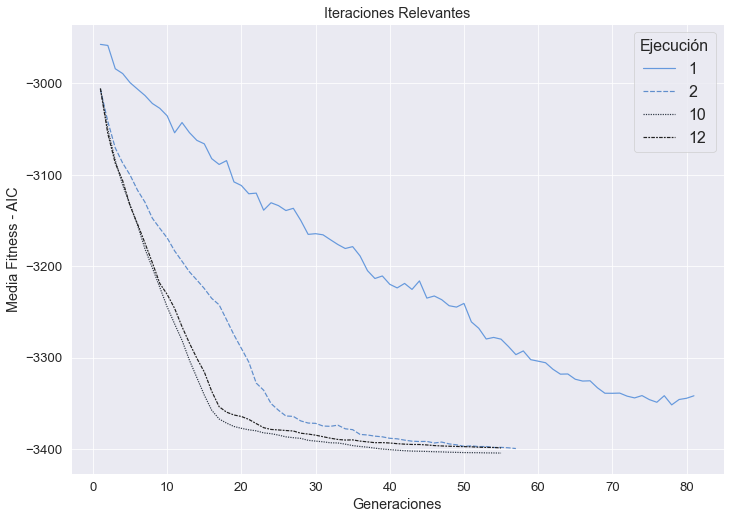

In [122]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", font_scale=1.5) 

sns.lineplot(data = dataframe_final[dataframe_final['ejecucion'].isin([1,2,10,12])]
             , x = "iteracion"
             , y = "media_fitness"
             , hue = "ejecucion"
             , style = "ejecucion"
             , palette = sns.dark_palette("#69d", reverse=True, as_cmap=True)
            ).set(title='Iteraciones Relevantes'
                  , xlabel='Generaciones'
                  , ylabel='Media Fitness - AIC')

plt.legend(title='Ejecución'
           , loc='upper right'
           , labels=['1'
                     , '2'
                     , '10'
                     , '12']
           , fontsize='16'
           , title_fontsize='16')

In [129]:
dataframe_final['ejecucion'] = dataframe_final['ejecucion'] - 14

In [130]:
dataframe_final

,iteracion,media_fitness,nro_cromosomas,nro_variables,segundos,ejecucion
0,1.0,-2957.351684,476.0,3.588235,51.427012,-13
1,2.0,-2958.518611,454.0,3.762115,103.673003,-13
2,3.0,-2984.003799,432.0,3.877315,144.781012,-13
3,4.0,-2989.283361,412.0,3.951456,181.661012,-13
4,5.0,-2999.289693,392.0,4.063776,216.090012,-13
5,6.0,-3006.327050,374.0,4.184492,246.140012,-13
6,7.0,-3013.255452,356.0,4.317416,277.077002,-13
7,8.0,-3022.025756,340.0,4.373529,306.138013,-13
8,9.0,-3027.300085,324.0,4.500000,332.119012,-13
9,10.0,-3035.563180,308.0,4.646104,355.869012,-13


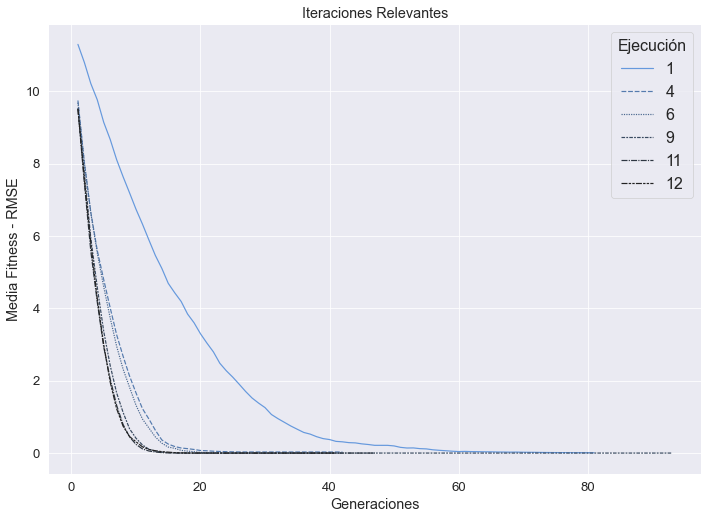

In [145]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", font_scale=1.5) 

sns.lineplot(data = dataframe_final[dataframe_final['ejecucion'].isin([1,4,6,9,11,13])]
             , x = "iteracion"
             , y = "media_fitness"
             , hue = "ejecucion"
             , style = "ejecucion"
             , palette = sns.dark_palette("#69d", reverse=True, as_cmap=True)
            ).set(title='Iteraciones Relevantes'
                  , xlabel='Generaciones'
                  , ylabel='Media Fitness - RMSE')

plt.legend(title='Ejecución'
           , loc='upper right'
           , labels=['1'
                     , '4'
                     , '6'
                     , '9'
                     , '11'
                    , '12']
           , fontsize='16'
           , title_fontsize='16')